# VVG-19
VGG19 is a variant of VGG model which in short consists of 19 layers (16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer). There are other variants of VGG like VGG11, VGG16 and others. VGG19 has 19.6 billion FLOPs

[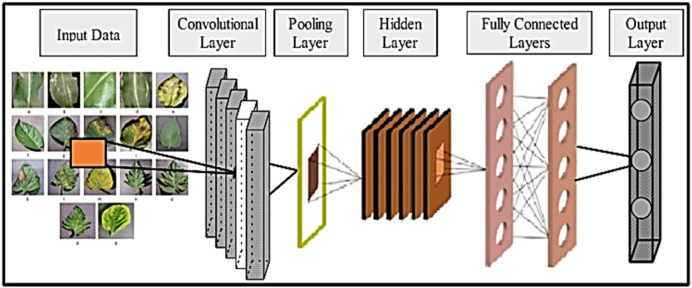](http://)



# Dataset used :

* 4000 train data without background + augmentation (800 image/genus)
* 2500 test data (500 image/genus)
* 185 test data from internet (25 cattleya and 40 other genus)



Dataset in this link  

[https://www.kaggle.com/raihanallaam/orchid-genus](http://)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/orchid-genus/orchid-genus/train',
                                                   target_size = (128,128),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 3200 images belonging to 5 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/orchid-genus/orchid-genus/train',
                                                  target_size = (128,128),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 800 images belonging to 5 classes.


In [5]:
test_dataset = test_datagen.flow_from_directory(directory = '../input/orchid-genus/orchid-genus/test',
                                                  target_size = (128,128),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 2500 images belonging to 5 classes.


(128, 128, 3)
(1, 128, 128, 3)


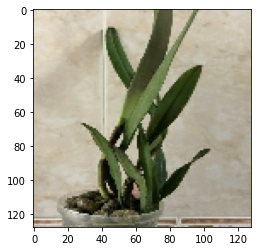

In [6]:
from keras.preprocessing import image
img = image.load_img("../input/orchid-genus/orchid-genus/inet/cattleya/C10.jpg",target_size=(128,128))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

In [7]:
base_model = tf.keras.applications.VGG19(input_shape=(128,128,3),include_top=False,weights="imagenet")

80142336/80134624 [==============================] - 2s 0us/step


In [8]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [9]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5,activation='softmax'))

In [10]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
dense (Dense)                (None, 32)                262176    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0

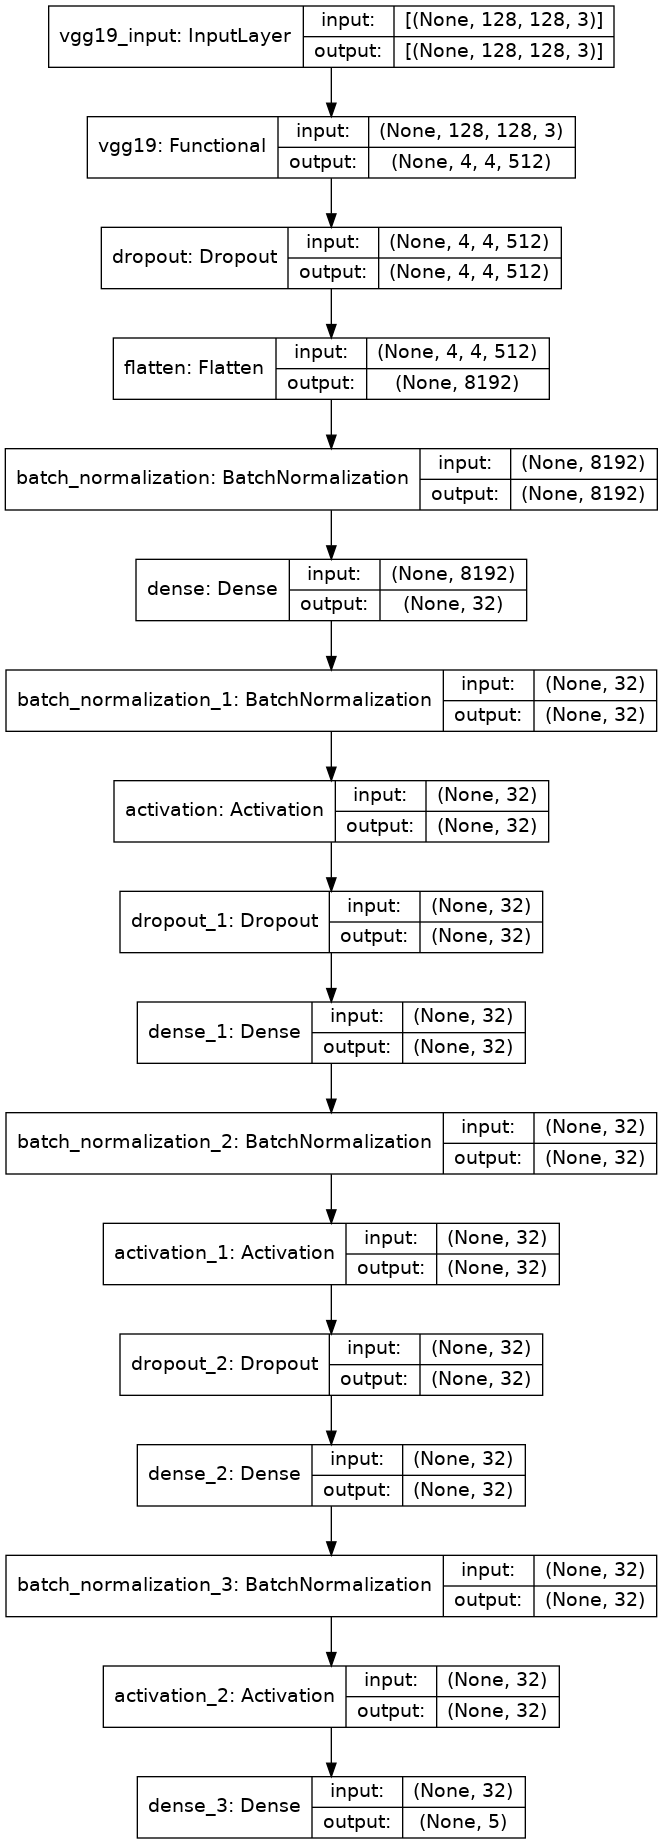

In [11]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [12]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [13]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [14]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 2,verbose = 1,factor = 0.75, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=2)

In [15]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [16]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 5,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/5
50/50 [==============================] - 388s 8s/step - loss: 1.3033 - accuracy: 0.8232 - precision: 0.6579 - recall: 0.2106 - auc: 0.7651 - f1_score: 0.3095 - val_loss: 1.5634 - val_accuracy: 0.8402 - val_precision: 0.6145 - val_recall: 0.5400 - val_auc: 0.8372 - val_f1_score: 0.5743
Epoch 2/5
50/50 [==============================] - 369s 7s/step - loss: 0.6135 - accuracy: 0.9155 - precision: 0.9352 - recall: 0.6202 - auc: 0.9703 - f1_score: 0.7429 - val_loss: 0.3621 - val_accuracy: 0.9443 - val_precision: 0.8862 - val_recall: 0.8275 - val_auc: 0.9840 - val_f1_score: 0.8560
Epoch 3/5
50/50 [==============================] - 381s 8s/step - loss: 0.3716 - accuracy: 0.9547 - precision: 0.9444 - recall: 0.8219 - auc: 0.9902 - f1_score: 0.8785 - val_loss: 0.1585 - val_accuracy: 0.9740 - val_precision: 0.9383 - val_recall: 0.9312 - val_auc: 0.9969 - val_f1_score: 0.9317
Epoch 4/5
50/50 [==============================] - 366s 7s/step - loss: 0.2446 - accuracy: 0.9737 - precision: 0

In [17]:
model.evaluate(test_dataset, verbose=1)

40/40 [==============================] - 187s 5s/step - loss: 1.8148 - accuracy: 0.8185 - precision: 0.5504 - recall: 0.5048 - auc: 0.7846 - f1_score: 0.5204


[1.814772129058838,
 0.8184798359870911,
 0.5503706932067871,
 0.504800021648407,
 0.7846425175666809,
 0.5204105377197266]

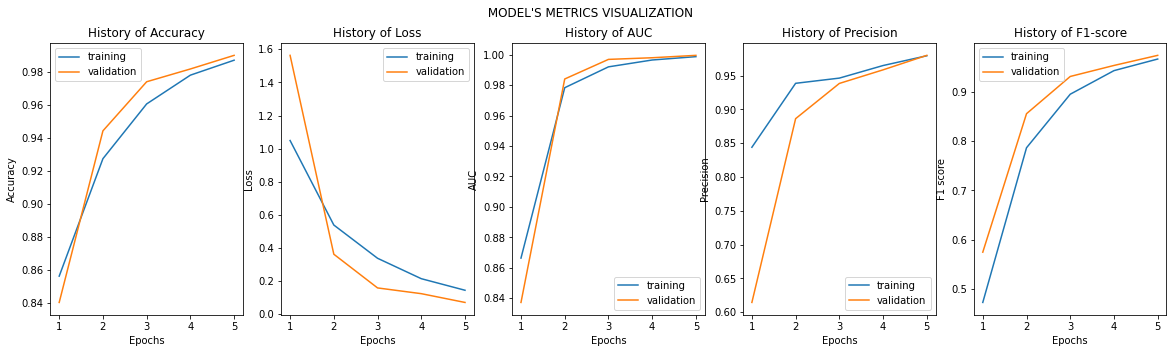

In [18]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )